In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
import random

import gym

In [2]:
class my_model(nn.Module):
    
    def __init__(self, env, hidden_layer_tuple = (16,8)):
        
        super(my_model, self).__init__()
        self.input_dim = env.observation_space.shape[0]
        self.output_dim = env.action_space.n # env.action_space
        
        self.fc1 = nn.Linear(self.input_dim, hidden_layer_tuple[0])
        self.fc2 = nn.Linear(hidden_layer_tuple[0], hidden_layer_tuple[1])
        self.fc3 = nn.Linear(hidden_layer_tuple[1], self.output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
                              
class DQNAgent():
    
    def __init__(self, env, hidden_layer_tuple = (32, 16), memory_capacity= 3000,
                change_target_after = 30, batch_size = 32,
                big_epsilon = 0.9, small_epsilon = 0.05, gamma = 0.9):
        '''Load the environment and initialize the agent'''
        
        self.env = env
        self.input = self.env.observation_space.shape[0]
        self.C = change_target_after
        self.N = batch_size
        self.replay_memory = self.init_replay_memory(memory_capacity, batch_size = batch_size)
        self.model = my_model(env, hidden_layer_tuple)
        self.target = my_model(env, hidden_layer_tuple)
        self.big_epsilon = big_epsilon
        self.small_epsilon = small_epsilon
        self.gamma = gamma
        
    def init_replay_memory(self, memory_capacity, batch_size):
        '''Initialize the replay memory. We play for batch_size rounds
        and load the memory with batch_size entries. In this way we can start training immediately.
        We construct and return a deque with maxlen the memory_capacity.'''
        
        deq = deque(maxlen=memory_capacity)
        
        s = torch.tensor(self.env.reset(), dtype = torch.float32).view((1, self.input))
        
        for _ in range(batch_size):
           
            
            a = self.env.action_space.sample()
            obs, reward, done, _ = self.env.step(a)
            
            deq.append([s, a, reward, torch.tensor(obs, dtype = torch.float32).view((1,self.input)), done])   
            s = torch.tensor(obs, dtype = torch.float32).view((1,4))
        
        self.env.reset()
        
        return deq      #Return deque, which goes to self.replay_memory
    
    def act(self, epsilon, s):
        
        random_prob = np.random.rand()
        
        if random_prob <= epsilon:
            a = self.env.action_space.sample()
        else:             
            a = int(torch.argmax(torch.squeeze(self.model(s))))
        
        return a   #return the action
    
       
    def learn(self, mini_batch, loss):
        '''This is the training loop. It takes a mini_batch and a
        loss function. It creates input X, target y and takes an optimization step.'''
        
        y = torch.tensor([], dtype = torch.float32)
        X = torch.tensor([], dtype = torch.float32)
        for s, a, rew, s_next, done in mini_batch:  
            
            target = rew
            
            if not done:
                target = rew + (self.gamma * torch.max(torch.squeeze(self.target(s_next))))
                        
            y = torch.cat((y, torch.tensor(target).view(1)))
            X = torch.cat((X, torch.squeeze(self.model(s))[a].view(1)))
        
        return loss(X, y)
                              
        
    def train(self, episodes, time_steps):
        
        rewards = []
        
        self.target.load_state_dict(self.model.state_dict())
        opt = optim.Adam(self.model.parameters(), lr = 0.001)
        counter = 0
        loss = F.mse_loss
        
        for episode in range(episodes):
            #Reduce randomness every epoch by multiplying with a factor less than 1.
            #In this way we ensure that we start acting less randomly, and mostly
            #are based in max Q-values
            
            if self.big_epsilon*0.995 >= self.small_epsilon:
                self.big_epsilon *= 0.995             
      
            s = torch.tensor(self.env.reset(), dtype = torch.float32).view((1,self.input))
        
            for t in range(time_steps):   #
                #at half the training, use ε-greedy policy with ε = self.small_epsilon
                #reduse epsilon linearly from big_epsilon to small_epsilon
                
                k = time_steps // 2  #the time that epsilon will become stable
                counter += 1
                if t <= k: 
                    epsilon = self.big_epsilon - (t/k)*(self.big_epsilon-self.small_epsilon)
                
                #At state s act, and take a choice  
                a = self.act(epsilon, s) 
                
                obs, reward, done, _ = env.step(a)
                
                #Append to replay_memory
                self.replay_memory.append([s, a, reward, torch.tensor(obs, dtype = torch.float32).view((1,4)), done])  
                
                #Save next state to s
                s = torch.tensor(obs, dtype = torch.float32).view((1,4))  
                
                #sample a batch from memory
                batch = random.sample(self.replay_memory, k = self.N)
                
                #Calculate and return the loss to output. Then optimize               
                output = self.learn(batch, loss)                              
                opt.zero_grad()
                output.backward()
                opt.step()
                              
                if counter == self.C:
                    self.target.load_state_dict(self.model.state_dict())
                    counter = 0
                    
                if done == True:
                    s = torch.tensor(self.env.reset(), dtype = torch.float32).view((1,4))
                    print("Episode {}/{} has reward {}".format(episode, episodes,t))
                    rewards.append(t)
                    break
                    
                if t == time_steps -1:
                    print("Episode {}/{} has reward {}".format(episode, episodes,t))

                    
        return self.model, rewards

/home/dimitris/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/dimitris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0/100 has reward 25
Episode 1/100 has reward 12
Episode 2/100 has reward 17
Episode 3/100 has reward 18
Episode 4/100 has reward 16
Episode 5/100 has reward 15
Episode 6/100 has reward 13
Episode 7/100 has reward 28
Episode 8/100 has reward 16
Episode 9/100 has reward 8
Episode 10/100 has reward 17
Episode 11/100 has reward 15
Episode 12/100 has reward 12
Episode 13/100 has reward 11
Episode 14/100 has reward 11
Episode 15/100 has reward 44
Episode 16/100 has reward 22
Episode 17/100 has reward 10
Episode 18/100 has reward 12
Episode 19/100 has reward 14
Episode 20/100 has reward 76
Episode 21/100 has reward 25
Episode 22/100 has reward 19
Episode 23/100 has reward 34
Episode 24/100 has reward 28
Episode 25/100 has reward 92
Episode 26/100 has reward 14
Episode 27/100 has reward 22
Episode 28/100 has reward 51
Episode 29/100 has reward 53
Episode 30/100 has reward 27
Episode 31/100 has reward 17
Episode 32/100 has reward 25
Episode 33/100 has reward 46
Episode 34/100 has reward

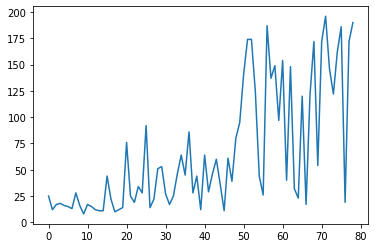

In [3]:
env = gym.make('CartPole-v1')

agent = DQNAgent(env, (32,32))
q_function, rewards = agent.train(100, 200)
plt.plot(rewards)

In [5]:
env.reset()

input_dim = env.observation_space.shape[0]

s = torch.zeros(1,input_dim)

for t in range(200):
    env.render()
    a = int(torch.argmax(q_function(s)))
    obs, rew, done, _ = env.step(a)
    s = torch.tensor(obs, dtype = torch.float32).view((1,input_dim))
   
env.close()